In [40]:
# Install necessary libraries (run these commands only if required)
# !pip install imbalanced-learn
#!pip install pandas scikit-learn

# Import necessary libraries
import pandas as pd
import zipfile
import requests
from io import BytesIO
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
# Import necessary libraries
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt






In [32]:
# Base URL for your GitHub repository
base_url = "https://github.com/orifelszer/CrimeData/raw/main/"

# File names
files = {
    "X_train": "X_train_supervised.zip",
    "X_test": "X_test_supervised.zip",
    "y_train": "y_train_supervised.zip",
    "y_test": "y_test_supervised.zip"
}



In [33]:
# Function to fetch and load data from the GitHub repository
def load_data_from_repo(file_name):
    url = base_url + file_name
    response = requests.get(url, timeout=60)  # 60-second timeout to avoid hangs
    if response.status_code == 200:
        with zipfile.ZipFile(BytesIO(response.content)) as z:
            # Assuming there's only one file in each zip
            extracted_file_name = z.namelist()[0]
            with z.open(extracted_file_name) as f:
                return pd.read_csv(f)
    else:
        raise Exception(f"Failed to download {file_name}. HTTP status code: {response.status_code}")

# Load datasets
try:
    X_train = load_data_from_repo(files["X_train"])
    X_test = load_data_from_repo(files["X_test"])
    y_train = load_data_from_repo(files["y_train"]).values.ravel()
    y_test = load_data_from_repo(files["y_test"]).values.ravel()
    print("Datasets loaded successfully!")
except Exception as e:
    print(f"Error loading data: {str(e)}")
    

Datasets loaded successfully!


In [34]:
# Handle imbalanced data using SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Use a smaller subset of the training data (30%) for faster training
X_train_sample = X_train_balanced.sample(frac=0.3, random_state=42)
y_train_sample = y_train_balanced[X_train_sample.index]

In [35]:
# Define the Random Forest Classifier with optimized parameters
rf_model = RandomForestClassifier(
    n_estimators=200,         # Number of trees in the forest
    max_depth=25,             # Maximum depth of the trees
    min_samples_split=2,      # Minimum number of samples required to split a node
    min_samples_leaf=1,       # Minimum number of samples required at a leaf node
    max_features='sqrt',      # Number of features to consider at each split
    class_weight='balanced',  # Handle class imbalance
    random_state=42
)



In [36]:
# Train the model
rf_model.fit(X_train_sample, y_train_sample)

# Evaluate the model on the test set
y_pred_rf = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
classification_report_rf = classification_report(y_test, y_pred_rf)

# Print results
print(f"Accuracy: {accuracy_rf * 100:.2f}%")
print("Classification Report:\n", classification_report_rf)

Accuracy: 4.74%
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.08      0.00       366
           1       0.08      0.14      0.11      7408
           2       0.01      0.17      0.03      3288
           3       0.09      0.04      0.06     23317
           4       0.39      0.04      0.07    126443
           5       0.06      0.17      0.09      6912
           6       0.00      0.10      0.00       126
           7       0.06      0.03      0.04     17566
           8       0.00      0.20      0.00       625
           9       0.18      0.02      0.04     59252
          10       0.37      0.05      0.09    128157
          11       0.00      0.17      0.01      1377
          12       0.01      0.21      0.01      2074
          13       0.00      0.05      0.00        60

    accuracy                           0.05    376971
   macro avg       0.09      0.11      0.04    376971
weighted avg       0.30      0.05      0

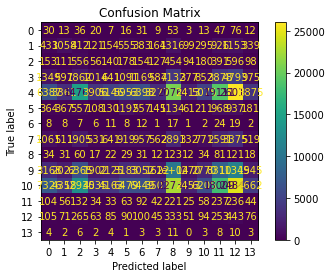

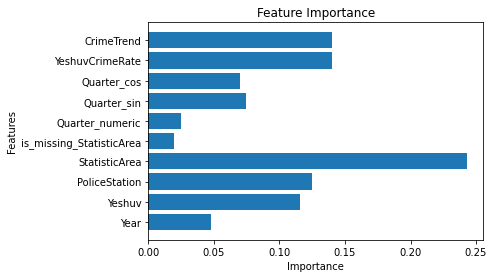

In [41]:
# Plot the confusion matrix
ConfusionMatrixDisplay.from_estimator(rf_model, X_test, y_test, cmap='viridis')
plt.title("Confusion Matrix")
plt.show()

# Feature importance analysis
feature_importances = rf_model.feature_importances_
features = X_train.columns
plt.barh(features, feature_importances)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.show()